In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = "/content/drive/MyDrive/ml/Titanic-Dataset.csv"


In [6]:
import pandas as pd

df = pd.read_csv(dataset_path)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
df.isnull().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [10]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns=['Cabin'], inplace=True)


/tmp/ipython-input-224943107.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-224943107.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])


In [12]:
df = df[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]


In [13]:
X = df.drop('Survived', axis=1)
y = df['Survived']


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


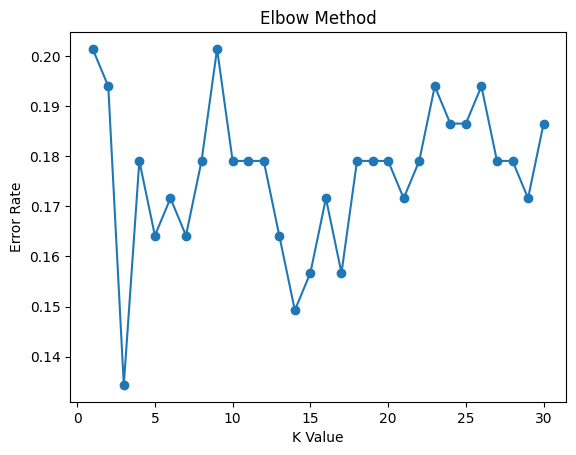

In [16]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

error_rate = []

for k in range(1,31):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_val)
    error_rate.append(np.mean(pred != y_val))

plt.plot(range(1,31), error_rate, marker='o')
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.title("Elbow Method")
plt.show()


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(3,21),
    'weights': ['uniform','distance'],
    'metric': ['euclidean','manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

grid.best_params_


{'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}

In [18]:
best_knn = grid.best_estimator_
best_knn.fit(X_train, y_train)


KNeighborsClassifier(metric='manhattan', n_neighbors=10)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = best_knn.predict(X_test)
y_prob = best_knn.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))


Accuracy: 0.7761194029850746
Precision: 0.7441860465116279
Recall: 0.6274509803921569
F1: 0.6808510638297872


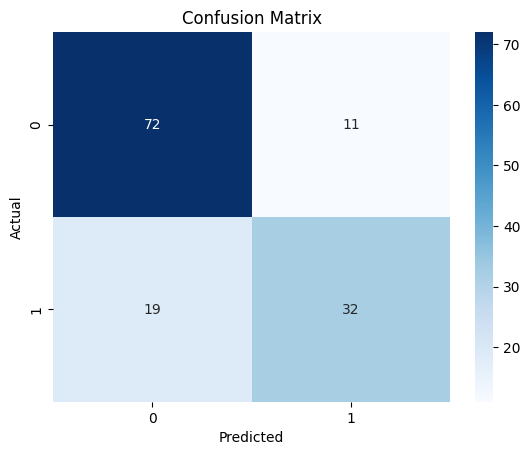

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


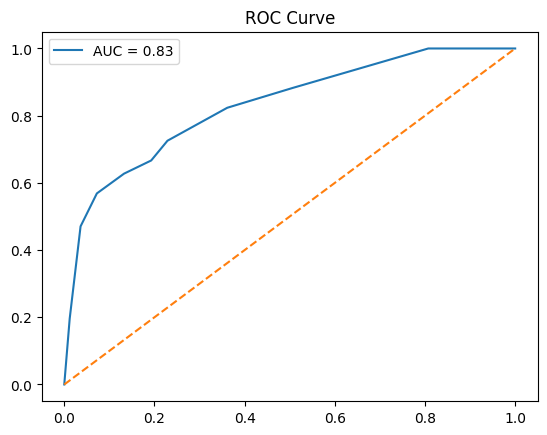

In [21]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title("ROC Curve")
plt.show()


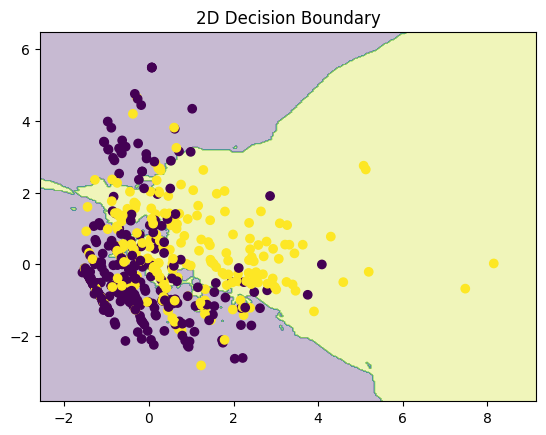

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

knn_2d = KNeighborsClassifier(n_neighbors=grid.best_params_['n_neighbors'])
knn_2d.fit(X_pca, y_train)

xx, yy = np.meshgrid(
    np.linspace(X_pca[:,0].min()-1, X_pca[:,0].max()+1, 300),
    np.linspace(X_pca[:,1].min()-1, X_pca[:,1].max()+1, 300)
)

Z = knn_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train)
plt.title("2D Decision Boundary")
plt.show()
